# Variational Autoencoder met Fashion MNIST

Een Variational Autoencoder (VAE) is een type autoencoder dat wordt gebruikt voor het genereren van nieuwe voorbeelden die vergelijkbaar zijn met de dataset waarop het is getraind. 
Het bestaat uit een encoder die de input data naar een lagere-dimensionale latente ruimte projecteert, en een decoder die uit deze latente ruimte nieuwe data reconstrueert.

Overzicht:
* Importeren van bibliotheken en dataset
* Definiëren van de VAE-architectuur
* Trainen van het VAE-model
* Genereren van nieuwe afbeeldingen met de VAE
## Importeren van packages en dataset

Eerst importeren we alle benodigde Python-bibliotheken voor het bouwen, trainen en visualiseren van onze VAE.
We gebruiken Pytorch voor het bouwen van het neurale netwerk, matplotlib voor visualisaties en NumPy voor numerieke berekeningen.
Daarna laden we de Fashion MNIST dataset, normaliseren de pixelwaarden naar de range [0,1] 
en splitsen de dataset in een trainings- en testset. We gebruiken DataLoader om mini-batches te maken voor training.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Check of GPU beschikbaar is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Apparaat gebruikt voor training: {device}")

# Definieer transformatie (normaliseren van beelden)
transform = transforms.Compose([
    transforms.ToTensor(),  # Converteer afbeeldingen naar PyTorch tensors
])

# Laad de Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Creëer DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Aantal trainingsbatches: {len(train_loader)}, Aantal testbatches: {len(test_loader)}")

Apparaat gebruikt voor training: cuda


100%|██████████| 26421880/26421880 [00:00<00:00, 30365994.95it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 606546.28it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 15950733.15it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6278649.90it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Aantal trainingsbatches: 469, Aantal testbatches: 79


## Definiëren van de VAE-architectuur

De architectuur van onze Variational Autoencoder bestaat uit een encoder die de inputbeelden naar een lagere-dimensionale latente ruimte projecteert en een decoder die deze latente ruimte gebruikt om de afbeeldingen opnieuw te genereren.
De verliesfunctie voor onze VAE, bestaande uit de som van de reconstructieverlies (binary cross-entropy)
en de KL-divergentie. We gebruiken de Adam optimizer voor het bijwerken van de gewichten van het netwerk.

In [2]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: [64, 7, 7]
            nn.ReLU(),
            nn.Flatten()  # Output: [64*7*7]
        )
        
        # Linear layers voor mu en logvar
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [1, 28, 28]
            nn.Sigmoid()   # om waarden te hebben tussen 0 en 1
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 64, 7, 7)  # reshape (omgekeerde van flatten naar 64,7,7
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Instantieer het model
latent_dim = 2
model = VariationalAutoencoder(latent_dim).to(device)
print(model)

def vae_loss(recon_x, x, mu, logvar):
    # Reconstructie verlies (binary cross-entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL-divergentie verlies
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Totale VAE verlies
    return recon_loss + kl_loss

# Definieer de optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=2, bias=True)
  (decoder_input): Linear(in_features=2, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


## Trainen van het VAE model

In deze cel trainen we het VAE-model met de trainingsgegevens. 
Voor elke epoch voeren we een forward pass, berekenen we het verlies, en voeren we een backward pass uit om de gewichten bij te werken.

In [3]:
# Aantal epochs
num_epochs = 10

# Training loop
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Bereken het verlies met de aangepaste BCE en KL-divergentie
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass en optimalisatie
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Gemiddelde verlies voor de huidige epoch
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 313.5411
Epoch [2/10], Loss: 278.6652
Epoch [3/10], Loss: 273.4959
Epoch [4/10], Loss: 271.0617
Epoch [5/10], Loss: 269.5689
Epoch [6/10], Loss: 268.6021
Epoch [7/10], Loss: 267.8589
Epoch [8/10], Loss: 267.2232
Epoch [9/10], Loss: 266.7232
Epoch [10/10], Loss: 266.2727


## Genereren van nieuwe resultaten

Eerst bestuderen we de latente ruimte door de testset in kaart te brengen in de 2D latente ruimte van de VAE. Hiermee kunnen we zien hoe goed de VAE leert om vergelijkbare afbeeldingen bij elkaar te plaatsen.
Daarna genereren we nieuwe afbeeldingen door willekeurige punten te nemen uit de latente ruimte 
en deze te decoderen met behulp van de decoder van de VAE.

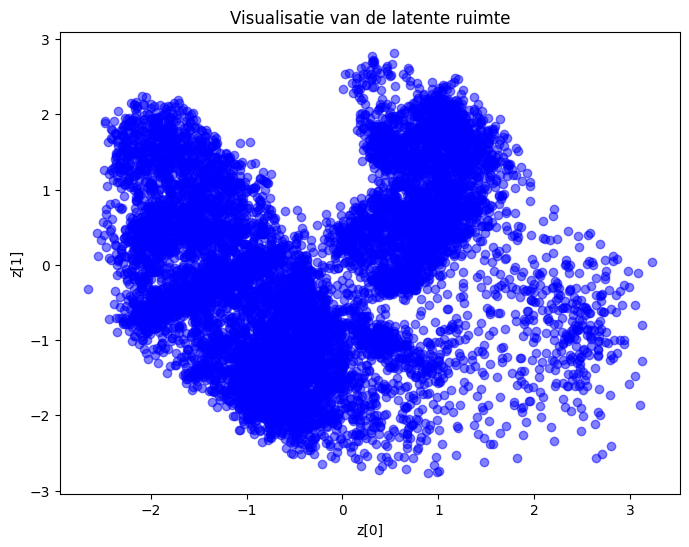

In [4]:
model.eval()
z_points = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        mu, _ = model.encode(images)
        z_points.append(mu.cpu().numpy())

# Zet alle latente punten in een array
z_points = np.concatenate(z_points)
plt.figure(figsize=(8, 6))
plt.scatter(z_points[:, 0], z_points[:, 1], c='blue', alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Visualisatie van de latente ruimte")
plt.show()

Text(0.5, 1.0, 'Gegenereerde afbeeldingen van random punten in de latente ruimte')

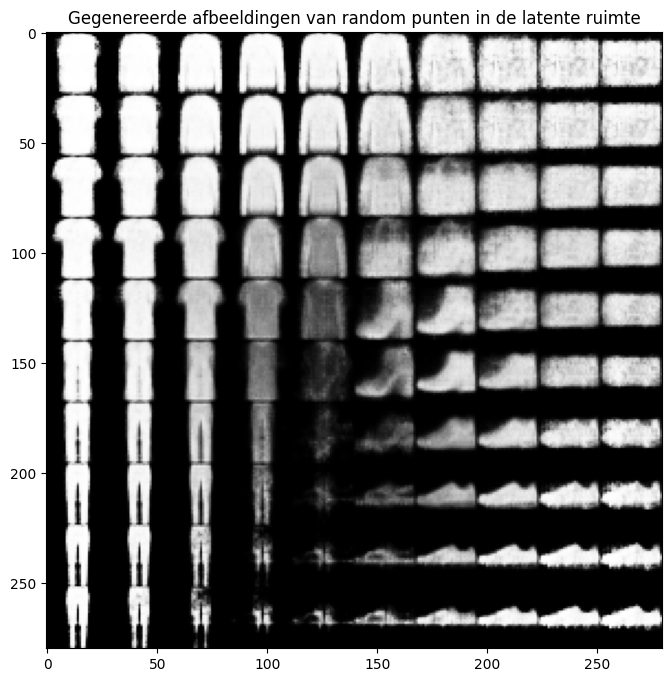

In [5]:
# Genereer nieuwe afbeeldingen van random punten in de latente ruimte
n = 10  # Aantal afbeeldingen per rij/kolom
figure = np.zeros((28 * n, 28 * n))

# Uniform verdeeld random punten in de latente ruimte
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decode(z_sample).cpu().numpy()
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(8, 8))
plt.imshow(figure, cmap='Greys_r')
plt.title("Gegenereerde afbeeldingen van random punten in de latente ruimte")

# Oefening: denoising autoencoder

Een denoising autoencoder (DAE) is een type autoencoder dat is ontworpen om ruis uit de invoergegevens te verwijderen. Het is een populaire techniek in deep learning voor het voorverwerken van gegevens, het leren van robuuste representaties, en voor compressiedoeleinden.

In deze oefening ga je een denoising autoencoder implementeren in PyTorch. Deze oefening omvat de volgende stappen:

* Data voorbereiden: We gebruiken de Fashion MNIST dataset, voegen ruis toe aan de afbeeldingen en schalen de gegevens naar het bereik [0, 1]. (Dit deel krijg je hieronder)
* Model bouwen: We bouwen een eenvoudig denoising autoencoder model met een encoder en een decoder.
* Model trainen: We trainen het model met ruisachtige afbeeldingen als invoer en niet-vervuilde afbeeldingen als doel.
* Resultaten evalueren: We testen het model door enkele ruisachtige afbeeldingen door het netwerk te laten gaan en hun gereconstrueerde versies weer te geven.

Data geladen en DataLoader klaar.


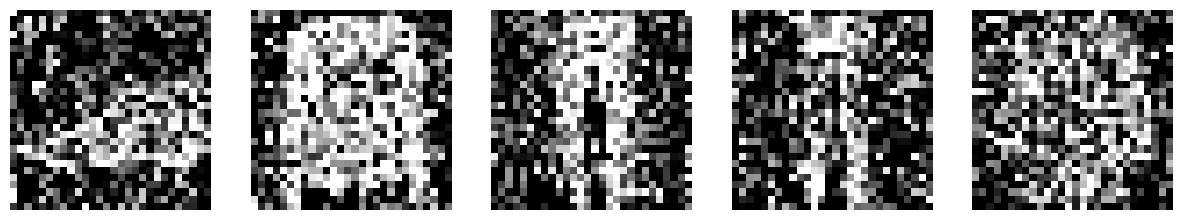

In [11]:
# Data voorbereiden

# Importeren van benodigde bibliotheken
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Controleer of er een GPU beschikbaar is, zo niet gebruik de CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data-transformatie: normaliseer de afbeeldingen zodat de pixelwaarden tussen 0 en 1 liggen
transform = transforms.Compose([
    transforms.ToTensor()  # Converteert beeld naar tensor en schaalt automatisch naar [0, 1]
])

# FashionMNIST dataset downloaden en laden
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader voor batches van de trainings- en testdata
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print("Data geladen en DataLoader klaar.")

# Functie om ruis aan de afbeeldingen toe te voegen
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
    return noisy_imgs

# Visualisatie van enkele ruisachtige afbeeldingen
examples = enumerate(test_loader)
batch_idx, (example_data, _) = next(examples)

noisy_imgs = add_noise(example_data)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    axes[i].imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()

In [12]:
# Model bouwen
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size=7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()   # om waarden te hebben tussen 0 en 1
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Model trainen

model_path = "01_denoising_model.pth"

if os.path.exists(model_path):
    print("Load existing model")

    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    print("Load done")
else:
    num_epochs = 10 
    for epoch in range(num_epochs):
        running_loss=0.0
        for img, _ in train_loader:
            img = data.to(img)
            noise_img = add_noise(img).to(device)
    
            # forward step
            outputs = model(noise_img)
            loss = criterion(outputs, img)
    
            # backwards
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        print(f"Epoch {epoch}/{num_epochs}: Loss: {running_loss / len(train_loader)}")
    
    mode.eval()
    
    # save the model
    torch.save(model.state_dict(), model_path)
    print("Model saved")

Load existing model
Load done


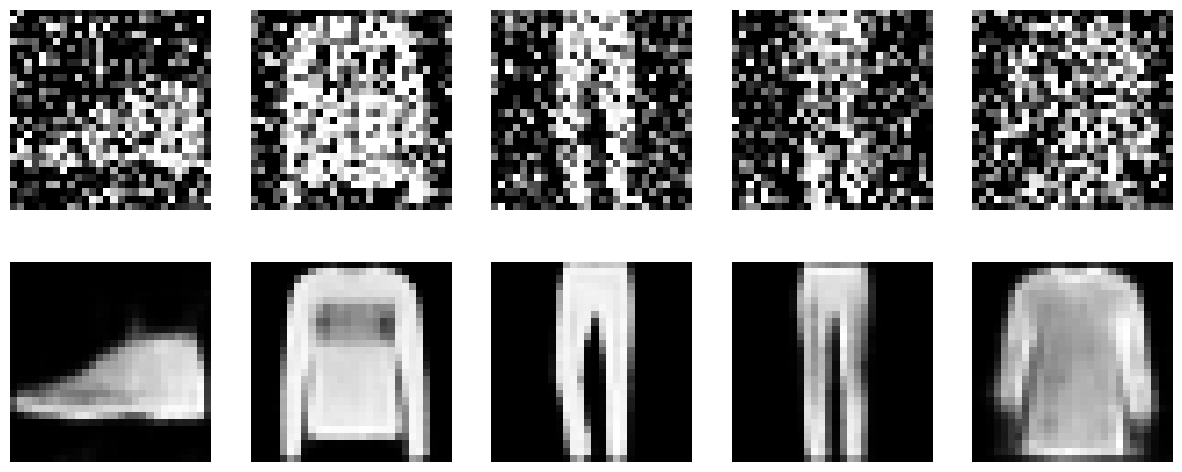

In [15]:
# Resultaten visualiseren
with torch.no_grad():
    # visualiseer 1 batch
    for batch in test_loader:
        imgs, _ = batch
        noise_imgs = add_noise(imgs).to(device)
        outputs = model(noise_imgs)

        fig,axes = plt.subplots(2, 5, figsize=(15,6))
        for i in range(5):
            axes[0, i].imshow(noise_imgs[i].cpu().squeeze().numpy(), cmap='gray') # squeeze om de eerste dimensie eraf te halen, numpy zodat matplotlib het kan tekenen
            axes[0, i].axis('off')

            axes[1, i].imshow(outputs[i].cpu().squeeze().numpy(), cmap='gray')
            axes[1, i].axis('off')

        
        break

plt.show()

# Wat te kennen voor auto-encoders

De belangrijke termen kennen

Variational auto encoder eerder op theorie niveau

Praktijk: verwacht ik ten minste dat je de denoising auto-encoder kan implementeren